# Bayesian Interferometry Model Pytorch implementation

Image Model:

$$I(x,y) =  \sum_{i=0}^{N_{basis}-1} \beta_i \psi(x,y)$$
where
$$
\psi_i(x,y) = \exp\left\{\ \left[\begin{array}{c}x - C_x^i\\
                                     y - C_y^i\end{array}\right]^T \Sigma^{-1}\left[\begin{array}{c}x - C_x^i\\
                                     y - C_y^i\end{array}\right]\right\}
$$

$$
\Sigma = \left[\begin{array}{cc}\sigma_1^2   & \sigma_{12} \\
                                 \sigma_{12} & \sigma_2^2 \end{array}\right]
$$
Visibility Model:

$$ V(u,v) = \sum_{i=1}^{N_{B}} \alpha_i \phi(u,v) $$

$$\phi(u,v) = \exp\left\{\frac{av^2+bu^2-cuv}{4ab-c^2} + j(fv+eu)\right\}$$
$$\alpha_i = \frac{\beta_i}{\sqrt{4ab-c^2}}$$
$$ a = -\frac{1}{2}\frac{\sigma_2^2}{\sigma_1^2\sigma_2^2 - \sigma_{12}^2} ; b = -\frac{1}{2}\frac{\sigma_1^2}{\sigma_1^2\sigma_2^2 - \sigma_{12}^2}; c = \frac{\sigma_{12}}{\sigma_1^2\sigma_2^2 - \sigma_{12}^2} $$
$$e = C_x^i; f = C_y^i$$

In [1]:
import numpy as np
import scipy as sp

In [2]:
def phi(u,v,a,b,c,e,f):
    return np.exp((a*v**2 + b*u**2 - c*u*v)/(4.*a*b-c**2) + 1j*(f*v+e*u))

def psi(x,y, a, b, c, e, f):
    invSigma = np.array([[-2.0*a,-c],[-c, -2.0*b]])
    if not isinstance(x,np.ndarray):
        xx = np.array([x-e,y-f])
    else:
        xx = np.stack([x-e,y-f], axis = 1).T
    
    return np.exp(-1./2*xx.T.dot(invSigma).dot(xx))

In [3]:
x = np.arange(0,1.01,0.01)
y = np.arange(0,1.01,0.01)
u = np.arange(-10,10,0.1)/0.01
v = np.arange(-10,10,0.1)/0.01

In [4]:
s1 = 0.01
s2 = 0.03
s12 = 0

a = -1./2*s2/(s1*s2-s12**2)
b = -1./2*s1/(s1*s2-s12**2)
c = s12/(s1*s2-s12**2)
invSigma = np.array([[-2.*a,-c],[-c, -2.*b]])
print(np.linalg.inv(invSigma))

e = .5
f = .5
g = np.zeros((x.shape[0],y.shape[0]))

for i in range(x.shape[0]):
    for j in range(y.shape[0]):
        g[i,j] = psi(x[i],y[j],a,b,c,e,f)
#         print(g[i,j])

[[ 0.01  0.  ]
 [ 0.    0.03]]


In [5]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

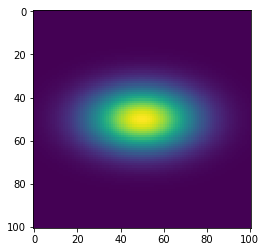

In [6]:
plt.imshow(g)

In [7]:
FTg = np.zeros((u.shape[0],v.shape[0]), dtype=np.complex)
for i in range(u.shape[0]):
    for j in range(u.shape[0]):
#         print(i,u[i],j,v[j])
        FTg[i,j] = phi(u[i],v[j],a,b,c,e,f)

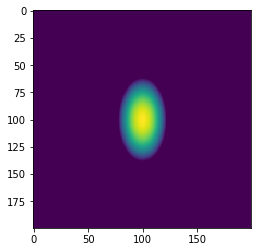

In [8]:
plt.imshow(np.log(np.abs(FTg)+10e-320))

# Edward

In [9]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

In [10]:
def build_toy_dataset(N=50, noise_std=0.1):
    x = np.linspace(-3, 3, num=N)
    y = np.cos(x) + np.random.normal(0, noise_std, size=N)
    x = x.astype(np.float32).reshape((N, 1))
    y = y.astype(np.float32)
    return x, y


def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.tanh(tf.matmul(x, W_0) + b_0)
    h = tf.matmul(h, W_1) + b_1
    return tf.reshape(h, [-1])

In [11]:
x_train = np.linspace(-3, 3, num=50)
y_train = np.cos(x_train) + np.random.normal(0, 0.1, size=50)
x_train = x_train.astype(np.float32).reshape((50, 1))
y_train = y_train.astype(np.float32).reshape((50, 1))

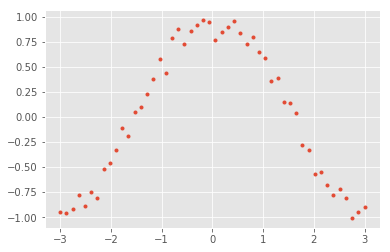

In [12]:
plt.plot(x_train,y_train,'.')

In [13]:
W_0 = Normal(loc=tf.zeros([1, 2]), scale=tf.ones([1, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=tf.matmul(tf.tanh(tf.matmul(x, W_0) + b_0), W_1) + b_1,
           scale=0.1)

In [14]:
qW_0 = Normal(loc=tf.Variable(tf.zeros([1, 2])),
              scale=tf.nn.softplus(tf.Variable(tf.zeros([1, 2]))))
qW_1 = Normal(loc=tf.Variable(tf.zeros([2, 1])),
              scale=tf.nn.softplus(tf.Variable(tf.zeros([2, 1]))))
qb_0 = Normal(loc=tf.Variable(tf.zeros(2)),
              scale=tf.nn.softplus(tf.Variable(tf.zeros(2))))
qb_1 = Normal(loc=tf.Variable(tf.zeros(1)),
              scale=tf.nn.softplus(tf.Variable(tf.zeros(1))))

In [15]:
# Sample functions from variational model to visualize fits.
rs = np.random.RandomState(0)
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [neural_network(x, qW_0.sample(), qW_1.sample(),
                    qb_0.sample(), qb_1.sample())
     for _ in range(10)])

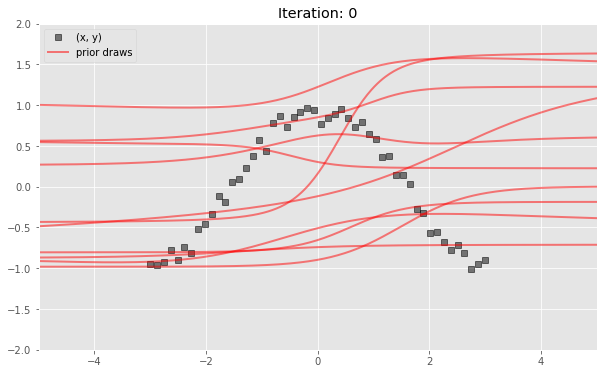

In [16]:
# FIRST VISUALIZATION (prior)

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

In [17]:
import edward as ed

inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 4s | Loss: -16.317


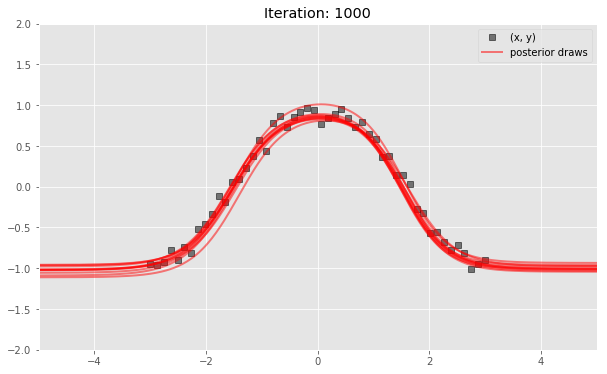

In [18]:
# SECOND VISUALIZATION (posterior)

outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()